In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import roc_auc_score

from scipy import sparse

from xgboost import XGBClassifier

%matplotlib inline

In [76]:
def write_submission_file(prediction, filename, timestamp=False):
    
    sample_submission = pd.read_csv('./../data/kaggle_flights/sample_submission.csv', index_col='id')
    sample_submission['dep_delayed_15min'] = prediction
    
    if timestamp:
        full_filename = '{}_{}.csv'.format(filename, datetime.now().strftime('%m%d_%H%M'))
    else:
        full_filename = '{}.csv'.format(filename)
    
    sample_submission.to_csv('./submissions/{}'.format(full_filename))

In [2]:
train_df = pd.read_csv('./../data/kaggle_flights/flight_delays_train.csv')
test_df = pd.read_csv('./../data/kaggle_flights/flight_delays_test.csv')

In [3]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


### process data

In [5]:
train_features = dict()
test_features = dict()

In [6]:
scaler = StandardScaler()
l_binarizer = LabelBinarizer()

In [7]:
train_distance = train_df['Distance'].astype('float64').values.reshape(-1, 1)
test_distance = test_df['Distance'].astype('float64').values.reshape(-1, 1)

scaler.fit(train_distance)

train_features['distance_scaled'] = scaler.transform(train_distance)
test_features['distance_scaled'] = scaler.transform(test_distance)

In [8]:
train_deptime = train_df['DepTime'].astype('float64').values.reshape(-1, 1)
test_deptime = test_df['DepTime'].astype('float64').values.reshape(-1, 1)

scaler.fit(train_deptime)

train_features['dep_time_scaled'] = scaler.transform(train_deptime)
test_features['dep_time_scaled'] = scaler.transform(test_deptime)

In [9]:
%%time

route_getter = lambda row: '{}-{}'.format(row['Origin'], row['Dest'])

train_route = train_df.apply(route_getter, axis=1)
test_route = test_df.apply(route_getter, axis=1)

l_binarizer.fit(train_route)

train_features['route'] = l_binarizer.transform(train_route)
test_features['route'] = l_binarizer.transform(test_route)

Wall time: 1min 27s


In [10]:
train_month = train_df['Month']
test_month = test_df['Month']

l_binarizer.fit(train_month)

train_features['month'] = l_binarizer.transform(train_month)
test_features['month'] = l_binarizer.transform(test_month)

In [11]:
train_dayofmonth = train_df['DayofMonth']
test_dayofmonth = test_df['DayofMonth']

l_binarizer.fit(train_dayofmonth)

train_features['dayofmonth'] = l_binarizer.transform(train_dayofmonth)
test_features['dayofmonth'] = l_binarizer.transform(test_dayofmonth)

In [12]:
train_dayofweek = train_df['DayOfWeek']
test_dayofweek = test_df['DayOfWeek']

l_binarizer.fit(train_dayofweek)

train_features['dayofweek'] = l_binarizer.transform(train_dayofweek)
test_features['dayofweek'] = l_binarizer.transform(test_dayofweek)

In [13]:
train_carrier = train_df['UniqueCarrier']
test_carrier = test_df['UniqueCarrier']

l_binarizer.fit(train_carrier)

train_features['carrier'] = l_binarizer.transform(train_carrier)
test_features['carrier'] = l_binarizer.transform(test_carrier)

### make datasets

In [14]:
for (key, val) in train_features.items():
    print('{} - {} ({})'.format(key, type(val), val.shape))

distance_scaled - <class 'numpy.ndarray'> ((100000, 1))
dep_time_scaled - <class 'numpy.ndarray'> ((100000, 1))
route - <class 'numpy.ndarray'> ((100000, 4429))
month - <class 'numpy.ndarray'> ((100000, 12))
dayofmonth - <class 'numpy.ndarray'> ((100000, 31))
dayofweek - <class 'numpy.ndarray'> ((100000, 7))
carrier - <class 'numpy.ndarray'> ((100000, 22))


In [15]:
for (key, val) in test_features.items():
    print('{} - {} ({})'.format(key, type(val), val.shape))

distance_scaled - <class 'numpy.ndarray'> ((100000, 1))
dep_time_scaled - <class 'numpy.ndarray'> ((100000, 1))
route - <class 'numpy.ndarray'> ((100000, 4429))
month - <class 'numpy.ndarray'> ((100000, 12))
dayofmonth - <class 'numpy.ndarray'> ((100000, 31))
dayofweek - <class 'numpy.ndarray'> ((100000, 7))
carrier - <class 'numpy.ndarray'> ((100000, 22))


In [16]:
%%time

X = sparse.csr_matrix(np.hstack(train_features.values()))
X_test = sparse.csr_matrix(np.hstack(test_features.values()))
y = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values.astype('int')

Wall time: 1min 36s


In [17]:
print(X.shape)
print(X_test.shape)
print(y.shape)

(100000, 4503)
(100000, 4503)
(100000,)


In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=14)

### logistic regression param search

In [19]:
lr_param_grid = {
    'class_weight': [None, 'balanced'],
    'C': np.logspace(-2, 1.5, 25)
}

In [20]:
lr_gs = GridSearchCV(LogisticRegression(random_state=14), lr_param_grid, scoring='roc_auc', cv=5, verbose=True, n_jobs=-1)

In [23]:
%%time

lr_gs.fit(X_train, y_train)

In [42]:
print(lr_gs.best_score_)
print(lr_gs.best_params_)

0.7011404569294575
{'C': 0.14677992676220697, 'class_weight': None}


**AWS results:**<br>
lr_gs.best_score_ = 0.7011404768621023<br>
lr_gs.best_params_ = {'C': 0.14677992676220697, 'class_weight': None}

In [45]:
best_lr = LogisticRegression(C=lr_gs.best_params_['C'], 
                             class_weight=lr_gs.best_params_['class_weight'])

### xgboost param search

In [33]:
xgb_param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20],
    'n_estimators': [200, 350, 500, 750, 1000]
}

In [34]:
xgb_gs = GridSearchCV(XGBClassifier(random_state=14), xgb_param_grid, scoring='roc_auc', cv=5, verbose=True, n_jobs=-1)

In [35]:
%%time

xgb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.7min finished


Wall time: 19min 6s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=14, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7, 10, 15, 20], 'n_estimators': [200, 350, 500, 750, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [36]:
print(xgb_gs.best_score_)
print(xgb_gs.best_params_)

0.7276439649763891
{'max_depth': 10, 'n_estimators': 500}


In [37]:
initial_fitted_xgb = XGBClassifier(max_depth=xgb_gs.best_params_['max_depth'], 
                                   n_estimators=xgb_gs.best_params_['n_estimators'], 
                                   random_state=14)

In [39]:
xgb_learn_rate_gs = GridSearchCV(initial_fitted_xgb, {'learning_rate': np.logspace(-3, 1.5, 30)}, 
                                 scoring='roc_auc', cv=5, verbose=True, n_jobs=-1)

In [40]:
xgb_learn_rate_gs.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 14.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=14, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': array([1.00000e-03, 1.42946e-03, 2.04336e-03, 2.92090e-03, 4.17532e-03,
       5.96846e-03, 8.53168e-03, 1.21957e-02, 1.74333e-02, 2.49202e-02,
       3.56225e-02, 5.09210e-02, 7.27895e-02, 1.04050e-01, 1.48735e-01,
       2.12611e-01, 3.03920e-01, 4.34441e-01, 6.21017e-01, 8.87720e-01,
       1.26896e+00, 1.81393e+00, 2.59294e+00, 3.70651e+00, 5.29832e+00,
       7.57374e+00, 1.08264e+01, 1.54759e+01, 2.21222e+01, 3.16228e+01])},
       pre_dispatch='2*n_jobs', refi

In [44]:
print(xgb_learn_rate_gs.best_score_)
print(xgb_learn_rate_gs.best_params_)

0.7277872917507907
{'learning_rate': 0.07278953843983153}


In [46]:
best_xgb = XGBClassifier(max_depth=xgb_gs.best_params_['max_depth'], 
                         n_estimators=xgb_gs.best_params_['n_estimators'], 
                         learning_rate=xgb_learn_rate_gs.best_params_['learning_rate'])

### stacking param search

In [60]:
%%time

cvp = cross_val_predict(best_xgb, X_valid, y_valid, method='predict_proba', cv=5, n_jobs=-1)

Wall time: 20.9 s


In [56]:
alpha_space = np.linspace(0.0, 1.0, 100)

In [61]:
stacked_scores = []

for idx, alpha in enumerate(alpha_space):
    lr_cvp = cross_val_predict(best_lr, X_valid, y_valid, method='predict_proba', cv=5, n_jobs=-1)
    xgb_cvp = cross_val_predict(best_xgb, X_valid, y_valid, method='predict_proba', cv=5, n_jobs=-1)
    stacked_prediction = alpha * lr_cvp + (1.0 - alpha) * xgb_cvp
    current_score = roc_auc_score(y_valid, stacked_prediction[:,1])
    stacked_scores.append(current_score)
    print(idx, end=' ')
print()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 


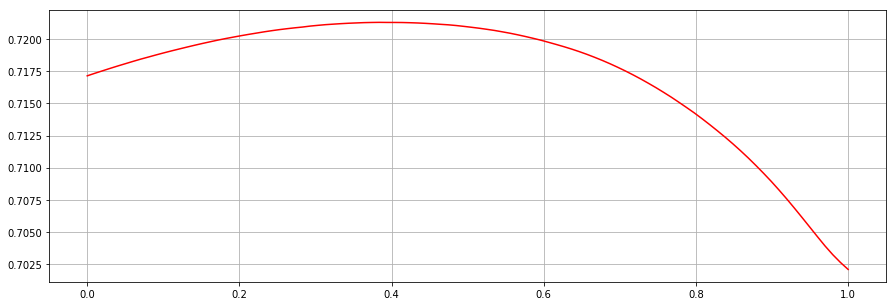

In [65]:
plt.figure(figsize=(15, 5))

plt.plot(alpha_space, stacked_scores, color='red', label='train')

#plt.ylim(0.94, 1.01)
#plt.xlim(18, 22)
plt.grid()
plt.show()

In [80]:
best_alpha = alpha_space[np.argmax(stacked_scores)]

print('best score:', np.max(stacked_scores))
print('best_alpha:', best_alpha)

best score: 0.7213089618364507
best_alpha: 0.38383838383838387


### make prediction

In [70]:
%%time

best_lr.fit(X, y)
best_xgb.fit(X, y)

Wall time: 39.5 s


In [72]:
test_prediction = (best_alpha * best_lr.predict_proba(X_test) + 
                   (1.0 - best_alpha) * best_xgb.predict_proba(X_test))[:,1]

In [79]:
write_submission_file(test_prediction, 'flights', True)